In [1]:
import sys
sys.path.insert(0, '..')
import os
import glob
from filament import filament
import datetime
import cmocean
import logging
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.basemap import Basemap
from importlib import reload
import matplotlib as mpl
reload(filament)
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cartopyticker
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="f")

In [2]:
logger = logging.getLogger("Sentinel3_chloro")
logger.setLevel(logging.INFO)
logging.info("Starting")
plotvis = 1

In [48]:
figdir = "../figures/chloro/"
datadir = "/data/Sentinel3/S3B_OL_2_WFR____20210113T11165..._037_2520_MAR_O_NT_002.SEN3"
datadir2 = "/data/Sentinel3/S3B_OL_2_WFR____20200721T10393..._222_2520_MAR_O_NT_002.SEN3"

## Regional domains

In [49]:
mediumdomain = (-19., -6., 25., 35.)
smalldomain = (-15., -9., 27., 33.)
tinydomain = (-12., -9., 29.5, 32.)
canarydomain = (-18.5, -13., 27.5, 29.5)
coordinates = mediumdomain

In [71]:
def load_sentinel3_chloro(datadir):
    
    lon = None
    lat = None
    chloro = None
    
    if os.path.exists(datadir):
        datafile = os.path.join(datadir, "chl_nn.nc")
        coordfile = os.path.join(datadir, "geo_coordinates.nc")
        
        if os.path.exists(datafile) & os.path.exists(coordfile):
    
            with netCDF4.Dataset(coordfile, "r") as nc:
                lon = nc.variables["longitude"][:]
                lat = nc.variables["latitude"][:]
            with netCDF4.Dataset(datafile, "r") as nc:
                #chloro = nc.variables["CHL_OC4ME"][:]
                chloro = nc.variables["CHL_NN"][:]
        else:
            logger.warning("Data file missing")
    else:
        logger.error("Data directory does not exist")
            
    return lon, lat, chloro    

In [72]:
lon, lat, c = load_sentinel3_chloro(datadir)
# lon2, lat2, c2 = load_sentinel3_chloro(datadir2)

### Projection

In [7]:
m = Basemap(projection='merc', llcrnrlon=lon.min(), llcrnrlat=lat.min(),
            urcrnrlon=lon.max(), urcrnrlat=lat.max(),
            lat_ts=0.5 * (lat.mean()), resolution='h')

In [39]:
mall = Basemap(projection='merc', llcrnrlon=min(lon2.min(), lon.min()), llcrnrlat=min(lat2.min(), lat.min()),
            urcrnrlon=max(lon2.max(), lon.max()), urcrnrlat=max(lat2.max(), lat.max()),
            lat_ts=0.5 * (lat2.mean()), resolution='i')

In [8]:
def get_domain_rec(lon, lat):
    lonrect = np.concatenate((lon[:,0].compressed(),
                              lon[-1,:].compressed(),
                              np.flipud(lon[:,-1].compressed()),
                              np.flipud(lon[0,:].compressed())))
    latrect = np.concatenate((lat[:,0].compressed(),
                              lat[-1,:].compressed(),
                              np.flipud(lat[:,-1].compressed()),
                              np.flipud(lat[0,:].compressed())))
                             
    return lonrect, latrect

In [52]:
lonr, latr = get_domain_rec(lon, lat)
# lonr2, latr2 = get_domain_rec(lon2, lat2)

In [53]:
lon.shape

(4091, 4865)

### Domains
Adjust ii, jj, kk and ll to ensure the selected domain falls where you want.

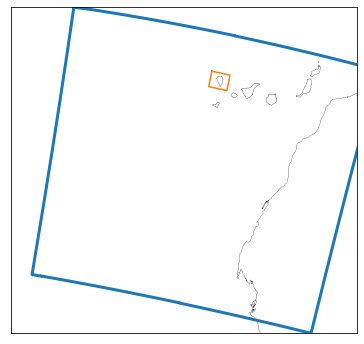

In [65]:
fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)

ii = 570
jj = 800
kk = 2300
ll = 2600
lonr2, latr2 = get_domain_rec(lon[ii:jj, kk:ll], lat[ii:jj, kk:ll])
#lonr3, latr3 = get_domain_rec(lon2[ii:jj, kk:ll], lat2[ii:jj, kk:ll])

m.plot(lonr, latr, latlon=True, linewidth=3)
m.plot(lonr2, latr2, latlon=True)
m.drawcoastlines(linewidth=0.25, color="k")
plt.show()

## Plot

In [66]:
chloro = filament.Chloro()
chloro.lon = lon[ii:jj, kk:ll]
chloro.lat = lat[ii:jj, kk:ll]
chloro.field = c[ii:jj, kk:ll]

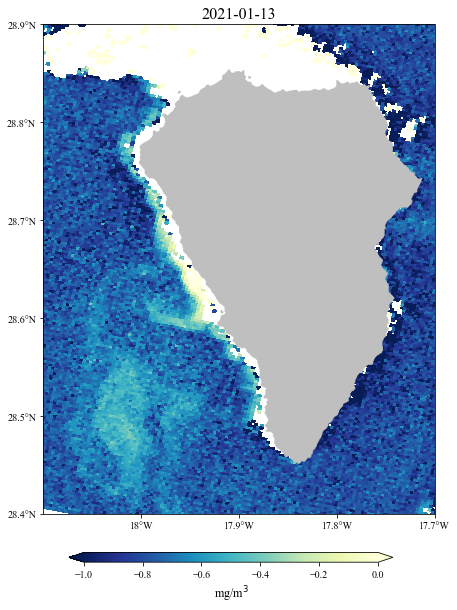

In [85]:
fig = plt.figure(figsize=(9, 9))
ax = plt.subplot(111, projection=myproj)
#plt.title(datetime.datetime.strftime(chloro.date, "%Y-%m-%d"), fontsize=16)
plt.title("2021-01-13", fontsize=16)
chloro.add_to_plot(fig, ax, domain=lapalmadomain, cmap=plt.cm.YlGnBu_r,
                clim=[-1., 0.], vis=False,
                cbarloc=[0.25, 0.05, 0.5, 0.015],
                alpha=1, extend="both")

ax.add_feature(coast, linewidth=.2, color=".75")
filament.decorate_map(ax, lapalmadomain, np.arange(-18., -11., 0.1), 
                      np.arange(27.5, 29.5, 0.1))
plt.savefig(os.path.join(figdir, "chloro_S3_20210113.png"), dpi=300, bbox_inches="tight",
           facecolor="w", transparent=False)
plt.show()
plt.close()

In [83]:
lapalmadomain = [-18.1, -17.7, 28.4, 28.9]